In [2]:
from micromind import Metric

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import random
import importlib
import numpy as np

from tqdm import tqdm

batch_size = 64

In [12]:
from micromind import MicroMind
from micromind.networks import PhiNet

import torch
import torch.nn as nn

model_path = "../code/finetunecifar100/pretrained/v7/finetuned/state-dict.pth.tar"

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available: 
    device = torch.device("mps")
    print("Running on the MPS")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class ImageClassification(MicroMind):

    # test 1 with n as input vector size and m classes custom d
    # n has to be calculated from the output of the neural network of the feature extractor
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.input = 344
        self.output = 100

        self.modules["feature_extractor"] = PhiNet(
            input_shape=(3, 224, 224),
            alpha=0.9,
            num_layers=7,
            beta=0.5,
            t_zero=4.0,
            include_top=False,
            num_classes=1000,
            compatibility=False,
            divisor=8,
            downsampling_layers=[4,5,7]
        )

        # Taking away the classifier from pretrained model
        pretrained_dict = torch.load(model_path, map_location=device)        

        #loading the new model
        self.modules["feature_extractor"].load_state_dict(pretrained_dict["feature_extractor"])        
        for _, param in self.modules["feature_extractor"].named_parameters():    
            param.requires_grad = False

        self.modules["classifier"] = nn.Sequential(                
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.input, self.output)
        )
        self.modules["classifier"].load_state_dict(pretrained_dict["classifier"])

    def forward(self, batch):        
        x = self.modules["feature_extractor"](batch)    
        x = self.modules["classifier"](x)    
        return x

    def compute_loss(self, pred, batch):
        return nn.CrossEntropyLoss()(pred, batch[1])                   
        

Running on the MPS


In [110]:
train_transform = transforms.Compose(
        [                  
         transforms.Resize((160, 160), antialias=True), 
         transforms.RandomHorizontalFlip(0.5),
         transforms.RandomRotation(10),
         transforms.ToTensor(), 
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903))
        ] 
    )

trainset = torchvision.datasets.CIFAR100(
    root="../_data/cifar-100", train=True, download=True, transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=2,    
)

Files already downloaded and verified


In [6]:
test_transform = transforms.Compose(
        [         
         transforms.Normalize((0.5070751592371323, 0.48654887331495095, 0.4409178433670343), (0.26733428587941854, 0.25643846292120615, 0.2761504713263903)), 
         transforms.Resize((160, 160), antialias=True), 
         transforms.ToTensor(), 
        ] 
    )

trainset = torchvision.datasets.CIFAR100(
    root="../data/cifar-100", train=False, download=True, transform=train_transform
)

test_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2,    
)

Files already downloaded and verified


In [111]:
model = ImageClassification()

In [112]:
# creating tensors 
x = torch.tensor([]) 
y = torch.tensor([]) 
  
# printing above created tensors 
print("Tensor x:", x) 
print("Tensor y:", y) 
  
# join above tensor using "torch.stack()" 
print("join tensors:") 
t = torch.stack((x,y)) 
print(t)

Tensor x: tensor([])
Tensor y: tensor([])
join tensors:
tensor([], size=(2, 0))


In [123]:
device = 'mps'

model.modules.to(device)
it = iter(train_loader)

batch = next(it)
batch = [x.to(device) for x in batch]

print(batch[0].shape)

x = model(batch[0])
y = batch[1]

for j in range(780):    
    batch = next(it)
    batch = [x.to(device) for x in batch]

    output = model(batch[0]).to(device)
    labels = batch[1].to(device)

    x = torch.cat((x, output))
    y = torch.cat((y, labels))    


torch.Size([64, 3, 160, 160])


In [124]:
len(trainset)//64

781

In [13]:
model.modules.to(device)
it = iter(test_loader)

batch = next(it)
batch = [x.to(device) for x in batch]

x = model(batch[0])
y = batch[1]

for j in range(156):    
    batch = next(it)
    batch = [x.to(device) for x in batch]

    output = model(batch[0]).to(device)
    labels = batch[1].to(device)

    x = torch.cat((x, output))
    y = torch.cat((y, labels))  

In [125]:
import pickle

with open('embeddings_all_2.pkl', 'wb') as file:
    pickle.dump({"outputs":x.to('cpu'), "labels":y.to('cpu')}, file)    

In [16]:
# with open('embeddings_all_l0.9_test.pkl', 'wb') as file:
#     pickle.dump({"outputs":x.to('cpu'), "labels":y.to('cpu')}, file)    

In [126]:
complete_mapping   = {4: 0, 30: 1, 55: 2, 72: 3, 95: 4, 1: 5, 32: 6, 67: 7, 73: 8, 91: 9, 54: 10, 62: 11, 70: 12, 82: 13, 92: 14, 47: 15, 52: 16, 56: 17, 59: 18, 96: 19, 0: 20, 51: 21, 53: 22, 57: 23, 83: 24, 9: 25, 10: 26, 16: 27, 28: 28, 61: 29, 22: 30, 39: 31, 40: 32, 86: 33, 87: 34, 5: 35, 20: 36, 25: 37, 84: 38, 94: 39, 6: 40, 7: 41, 14: 42, 18: 43, 24: 44, 26: 45, 45: 46, 77: 47, 79: 48, 99: 49, 23: 50, 33: 51, 49: 52, 60: 53, 71: 54, 12: 55, 17: 56, 37: 57, 68: 58, 76: 59, 3: 60, 42: 61, 43: 62, 88: 63, 97: 64, 15: 65, 19: 66, 21: 67, 31: 68, 38: 69, 34: 70, 63: 71, 64: 72, 66: 73, 75: 74, 36: 75, 50: 76, 65: 77, 74: 78, 80: 79, 8: 80, 13: 81, 48: 82, 58: 83, 90: 84, 41: 85, 69: 86, 81: 87, 85: 88, 89: 89, 2: 90, 11: 91, 35: 92, 46: 93, 98: 94, 27: 95, 29: 96, 44: 97, 78: 98, 93: 99}

with open('embeddings_all_2.pkl', 'rb') as file:
    data = pickle.load(file)

X = torch.argmax(data["outputs"], dim=1).detach().numpy()
y = np.array([complete_mapping[x] for x in data["labels"].detach().numpy()])

In [131]:
print(X.shape)
print(y.shape)

(49984,)
(49984,)


In [132]:
print(X[:10])
print(y[:10])

[66 96 20 91  5 98 84 28 50 96]
[66 96 20 91  5 33 84 28 50 68]


In [133]:
accuracy = np.sum(X == y) / len(X)
print(accuracy)

0.6683938860435339


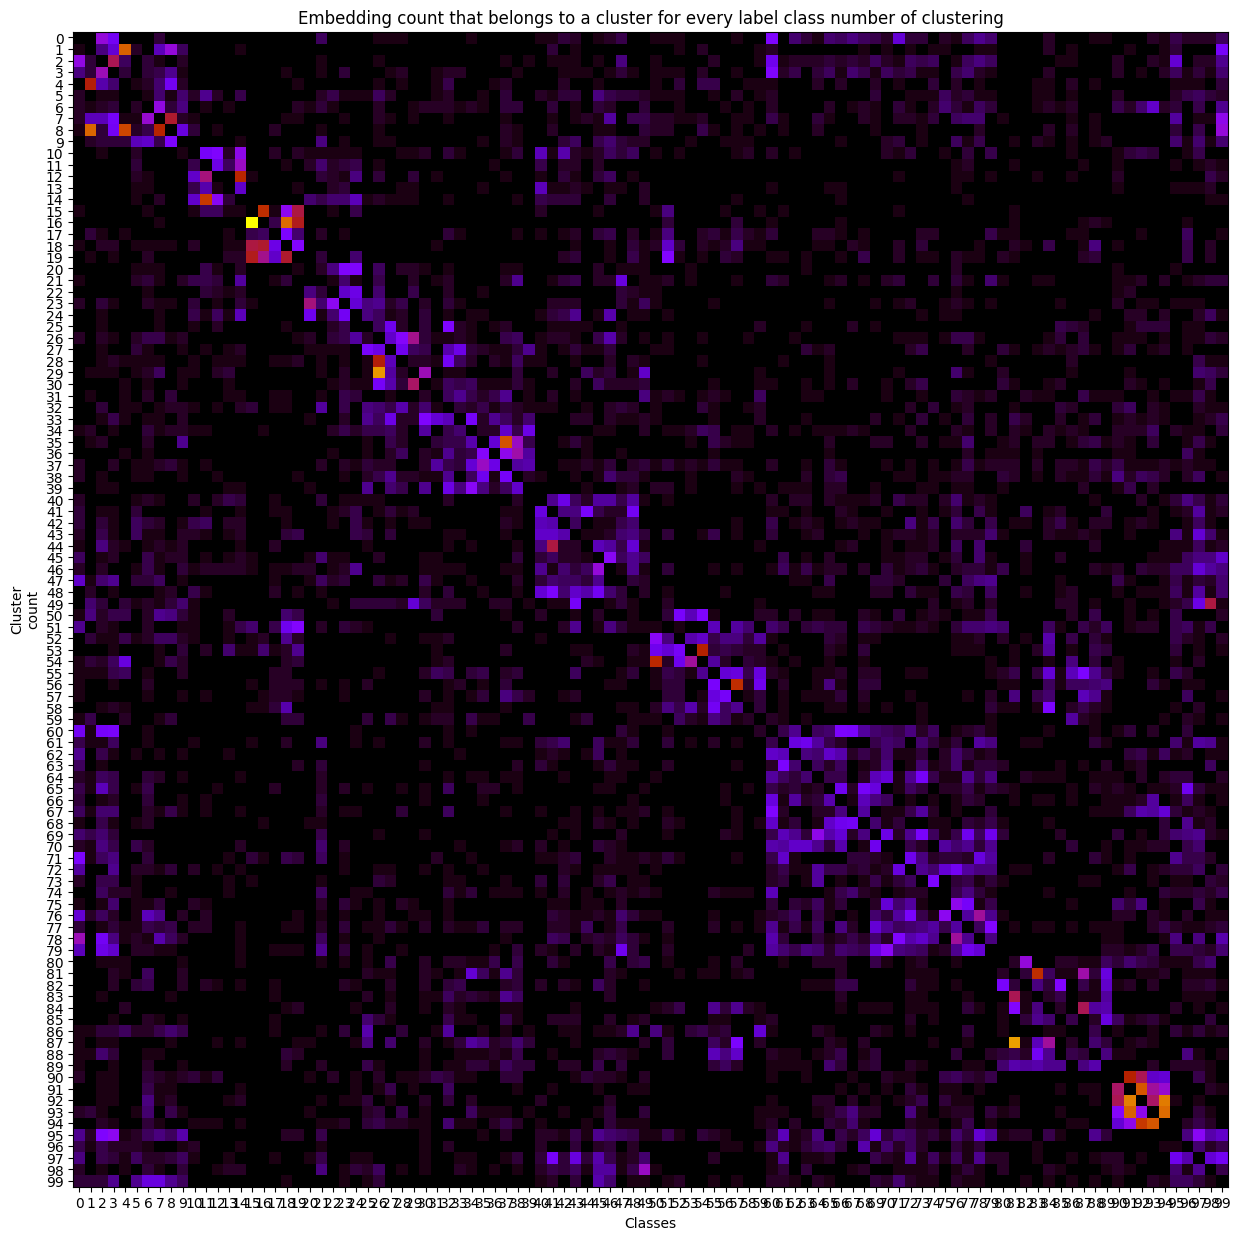

In [134]:
import matplotlib.pyplot as plt

a = np.zeros((100, 100))

for i in range(len(X)):
    if(X[i] != y[i]):
        a[X[i], y[i]] += 1
    #a[X[i], y[i]] += 1

plt.figure(figsize=(15,15))
plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Embedding count that belongs to a cluster for every label class number of clustering")

# add all the side tick labels
plt.xticks(range(100))
plt.yticks(range(100))

plt.imshow(a,cmap='gnuplot') 

19


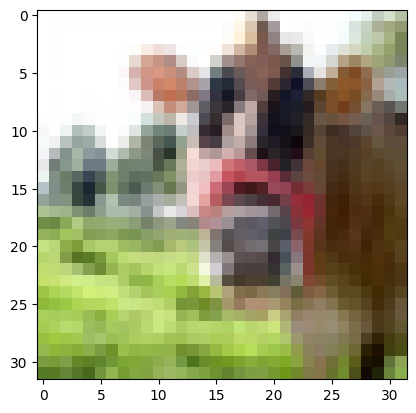

In [89]:
plt.imshow(trainset.data[0])
print(trainset.targets[0])

0 22 22
1 85 85
2 86 86
3 38 38
4 6 19
5 21 21
6 92 90
7 63 63
8 39 39
9 96 69
10 14 42
11 21 14
12 20 20
13 85 85
14 73 73
15 81 81
16 58 48
17 54 54
18 52 52
19 44 44
20 69 74
21 35 35
22 61 61
23 69 69
24 27 27
25 33 33
26 74 74
27 84 5
28 42 42
29 51 51
30 44 44
31 54 54
32 95 95
33 45 45
34 45 98
35 24 24
36 57 57
37 91 90
38 13 40
39 49 43
40 51 96
41 46 46
42 58 57
43 73 73
44 6 75
45 70 70
46 3 2
47 1 1
48 37 37
49 18 18
50 23 23
51 82 82
52 42 42
53 75 75
54 82 82
55 0 73
56 77 70
57 90 71
58 43 43
59 84 84
60 13 13
61 29 29
62 68 68
63 73 73
64 86 86
65 83 90
66 98 98
67 37 35
68 71 71
69 22 22
70 48 48
71 34 2
72 92 92
73 73 73
74 75 75
75 25 25
76 13 13
77 95 95
78 83 83
79 2 2
80 89 89
81 23 23
82 7 7
83 10 10
84 97 97
85 91 91
86 10 10
87 68 68
88 36 36
89 51 51
90 76 76
91 48 48
92 61 79
93 21 21
94 9 47
95 25 43
96 66 65
97 41 40
98 40 40
99 36 36


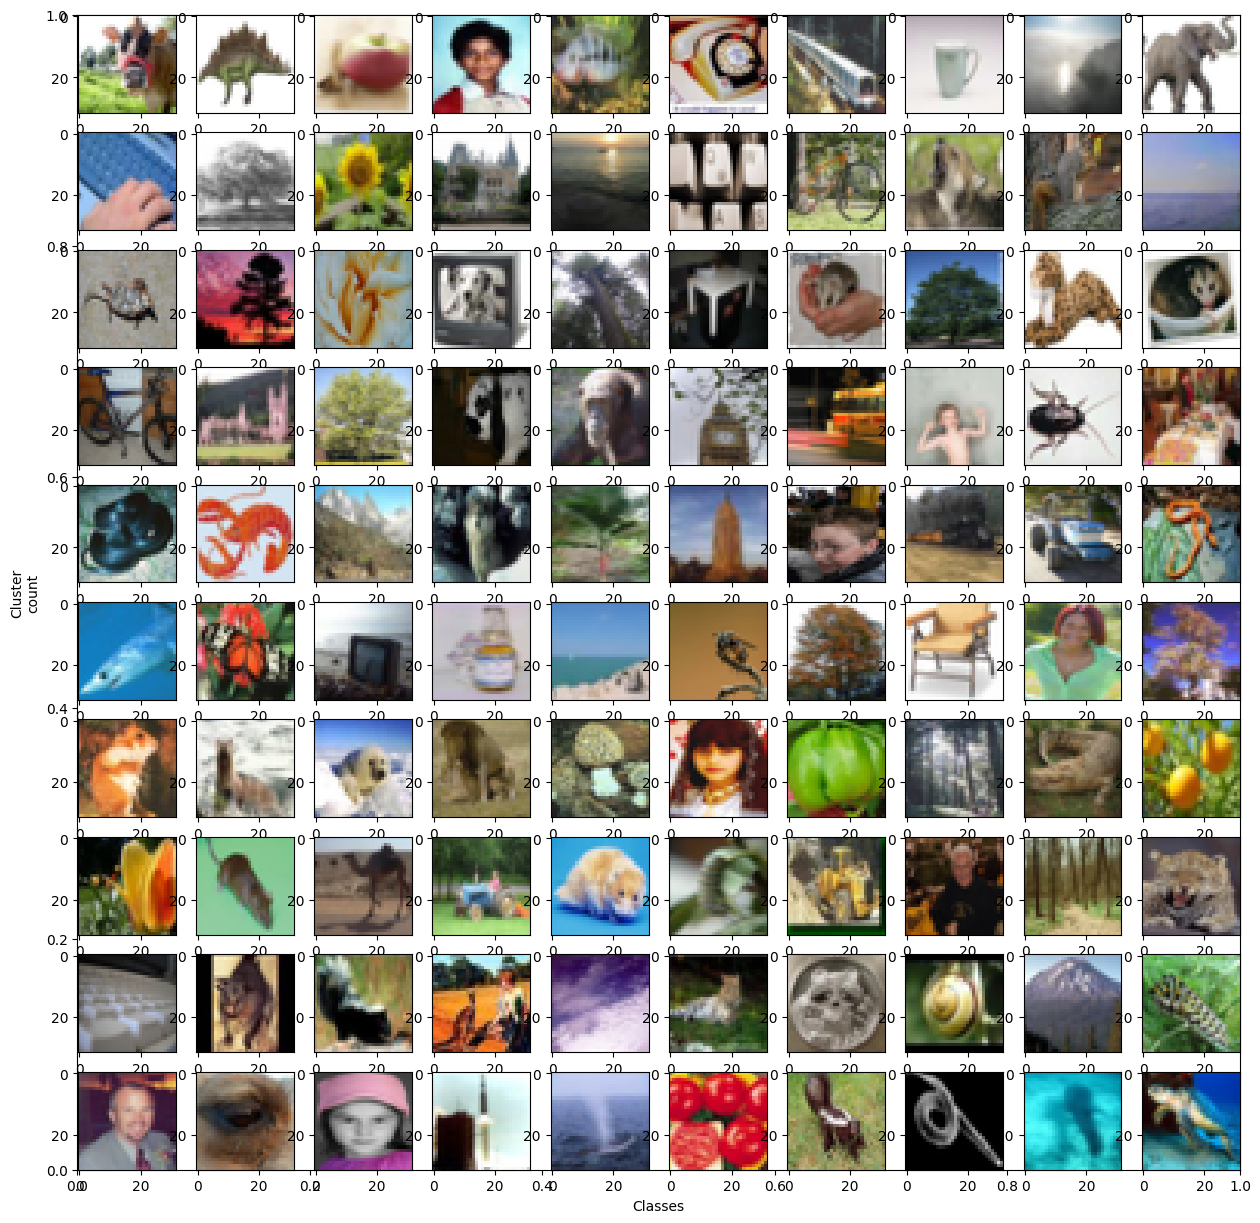

In [88]:
# create a table of images
plt.figure(figsize=(15,15))
plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")

for x in range(100):    
    print(x, X[x], y[x])
    plt.subplot(10,10,x+1)
    plt.imshow(trainset.data[x])


5 21 21
93 21 21
480 21 21
504 21 21
519 21 21
693 77 21
707 65 21
755 21 21
912 21 21
954 21 21
1036 21 21
1071 21 21
1094 70 21
1284 21 21
1485 21 21
1559 21 21
1602 21 21
1603 98 21
1883 21 21
2238 21 21
2532 8 21
2589 71 21
2608 90 21
2609 21 21
2622 19 21
2627 25 21
2635 21 21
2886 32 21
2891 11 21
3042 21 21
3295 21 21
3614 63 21
3962 21 21
4188 66 21
4208 21 21
4305 70 21
4307 69 21
4338 21 21
4644 21 21
4857 9 21
4934 5 21
4961 71 21
5147 69 21
5179 21 21
5323 74 21
5445 21 21
5505 21 21
5580 21 21
5745 18 21
5755 21 21
5843 51 21
5962 21 21
5977 21 21
6295 21 21
6362 21 21
6417 21 21
6625 21 21
6634 21 21
6820 21 21
6862 21 21
6935 63 21
7187 21 21
7252 0 21
7346 21 21
7470 21 21
7543 21 21
7568 21 21
7589 61 21
7610 21 21
7683 6 21
7710 21 21
7825 50 21
7882 21 21
7886 21 21
7918 5 21
7955 21 21
7959 21 21
8194 21 21
8214 21 21
8239 98 21
8275 21 21
8585 77 21
8829 21 21
8861 21 21
9159 79 21
9186 65 21
9335 98 21
9497 1 21
9499 21 21
9522 21 21
9755 21 21
9825 21 21
9904 21 

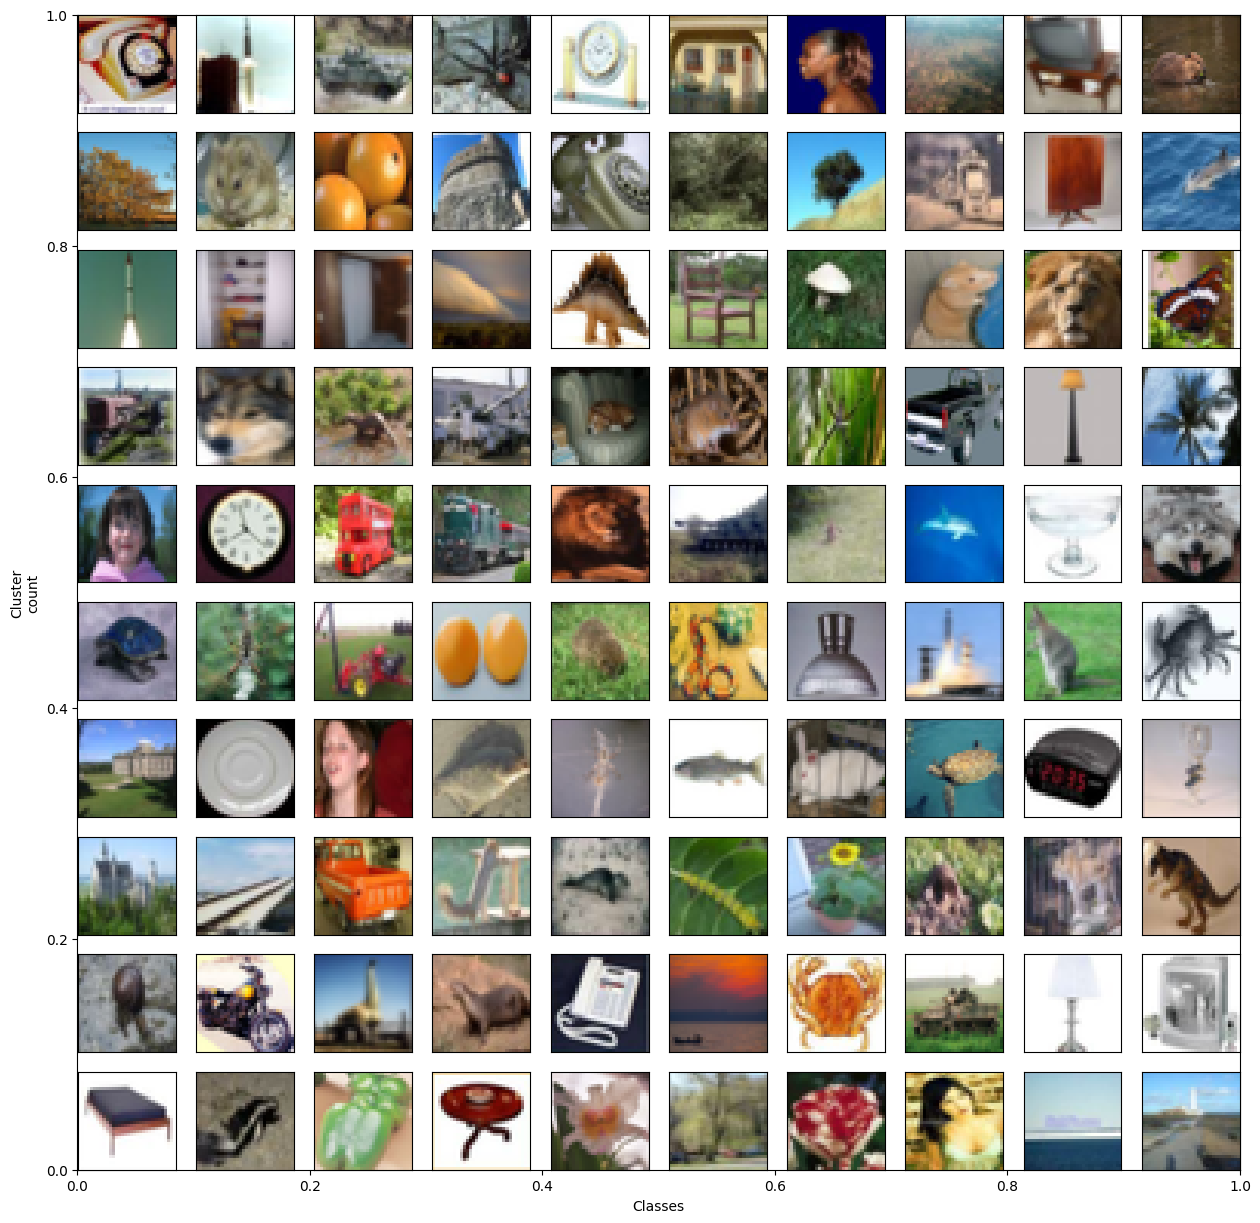

In [83]:
# create a table of images
plt.figure(figsize=(15,15))
plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")

added = 0
i = 0
while(added < 100):    
    if(y[i] == complete_mapping[51]):
        # print the image and image label and the predicted label
        print(i, X[i], y[i])
        plt.subplot(10,10,added+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(trainset.data[i], cmap=plt.cm.binary)
        added += 1
    i += 1



In [35]:
X = np.array(x)
print(X)

[22 85 86 ... 88 53 54]


In [47]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def kmeans_cosine(data, k, max_iter=100):
    # Normalize data
    data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)
    
    # Initialize centroids
    centroids = data_normalized[np.random.choice(data.shape[0], k, replace=False)]
    
    for _ in range(max_iter):
        # Compute cosine similarity and assign clusters
        similarity = cosine_similarity(data_normalized, centroids)
        clusters = np.argmax(similarity, axis=1)
        
        # Update centroids
        new_centroids = np.array([data_normalized[clusters == i].mean(axis=0) for i in range(k)])
        
        # Normalize new centroids
        new_centroids = new_centroids / np.linalg.norm(new_centroids, axis=1, keepdims=True)
        
        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return clusters, centroids

clusters, centroids = kmeans_cosine(embeddings, 10, max_iter=50)

print(clusters.shape)
print(centroids.shape)

(49984,)
(10, 344)


In [35]:
# mapping tra le 100 classi qui e le altre 100 classi di la
y

tensor([17,  3, 88,  ..., 82, 27, 66])

# Some checks

(array([500., 500., 500., 500., 500., 499., 500., 500., 500., 500., 500.,
        499., 500., 500., 500., 500., 500., 500., 500., 499., 500., 500.,
        500., 500., 500., 500., 500., 500., 499., 500., 500., 500., 500.,
        500., 500., 500., 500., 499., 500., 500., 500., 500., 500., 499.,
        500., 500., 500., 499., 500., 499., 500., 500., 500., 500., 500.,
        500., 500., 500., 500., 500., 500., 499., 500., 500., 500., 500.,
        500., 500., 500., 500., 499., 500., 500., 498., 499., 500., 500.,
        500., 500., 500., 500., 499., 500., 500., 499., 500., 500., 500.,
        499., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
        500.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.75, 25.74,
        26.73, 27.72, 28.71, 29.7 , 30.69, 31.68, 32.67, 33.66, 34.65,
        35.64, 36.63, 37.62, 38.61

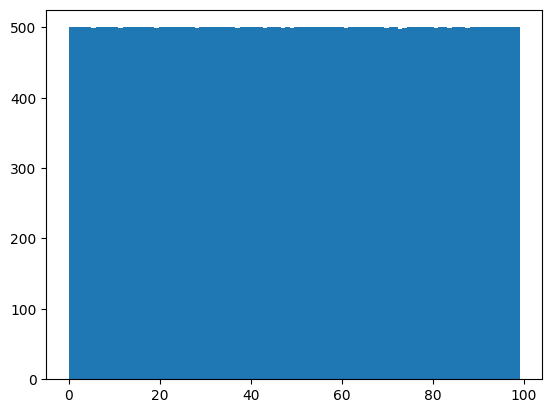

In [26]:
import matplotlib.pyplot as plt
plt.hist(y, bins=100)

In [28]:
len(np.unique(y))

100

In [29]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
a = np.zeros((100,100))

output

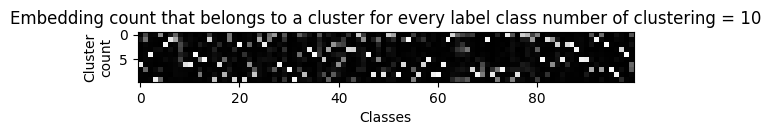

In [42]:
#fpr every label in 1 to 100 we want to see how many go to 

# matrix 10 x 100 -> for every row we see where how many labels from x target go to that cluster

a = np.zeros((100,100))

#print(a)

for i, cluster in enumerate(clusters):
    a[cluster][y[i]] += 1

plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Embedding count that belongs to a cluster for every label class number of clustering = " + str(centroids.shape[0]))
plt.imshow(a,cmap='Greys_r')



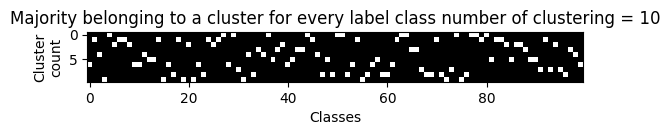

In [43]:
## majority voting for each class
b = np.argmax(a, axis=0)

c = np.zeros((centroids.shape[0],100))
for x in range(100):    
    c[b[x]][x] = 1

plt.xlabel("Classes")
plt.ylabel("Cluster\ncount")
plt.title("Majority belonging to a cluster for every label class number of clustering = " + str(centroids.shape[0]))
plt.imshow(c, cmap='Greys_r')

In [44]:
# use the second matrix as a mask 

false_negative = np.sum(np.ma.array(a,mask=c))
print(false_negative)

15193.0


In [46]:
false_negative/clusters.shape[0]

0.3039572663252241

In [17]:
# map each line to cluster: label to cluster belonging

maps = {}

for i, x in enumerate(c):
    for j, y in enumerate(x):
        if(y==1):
            maps[j] = i
    
print(maps)

{0: 0, 1: 0, 53: 0, 54: 0, 57: 0, 62: 0, 70: 0, 82: 0, 83: 0, 92: 0, 4: 1, 27: 1, 29: 1, 32: 1, 44: 1, 50: 1, 51: 1, 63: 1, 64: 1, 74: 1, 75: 1, 77: 1, 78: 1, 80: 1, 2: 2, 5: 2, 11: 2, 20: 2, 25: 2, 35: 2, 36: 2, 39: 2, 46: 2, 84: 2, 86: 2, 87: 2, 94: 2, 98: 2, 3: 3, 15: 3, 19: 3, 21: 3, 31: 3, 34: 3, 38: 3, 42: 3, 43: 3, 65: 3, 66: 3, 88: 3, 97: 3, 6: 4, 7: 4, 14: 4, 18: 4, 24: 4, 26: 4, 45: 4, 79: 4, 30: 5, 55: 5, 67: 5, 72: 5, 73: 5, 91: 5, 93: 5, 95: 5, 9: 6, 10: 6, 16: 6, 22: 6, 23: 6, 28: 6, 40: 6, 60: 6, 61: 6, 69: 6, 71: 6, 99: 6, 12: 7, 17: 7, 37: 7, 49: 7, 68: 7, 76: 7, 90: 7, 8: 8, 13: 8, 41: 8, 48: 8, 58: 8, 81: 8, 85: 8, 89: 8, 33: 9, 47: 9, 52: 9, 56: 9, 59: 9, 96: 9}


In [28]:
np.sum(c, axis=1)

array([ 8.,  7.,  9.,  7., 19.,  8.,  6., 18.,  6., 12.])